<a href="https://colab.research.google.com/github/Ratnesh-bhosale/Federated_Learning/blob/main/FL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [ ]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

In [ ]:
from imblearn.over_sampling import SMOTE 
def split_data(path, clients_num):

  data = pd.read_csv(path)


  
  y = data.pop('islate')
  X = data
  # SMOTE
  sm = SMOTE(random_state=42,sampling_strategy='auto')
  X, y = sm.fit_resample(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X.values,y.values.reshape(-1, 1),random_state=42)
  

  y_train = np.concatenate([1 - y_train, y_train], 1)
  y_test = np.concatenate([1 - y_test, y_test], 1)
  

  X_train = np.array_split(X_train, clients_num)
  y_train = np.array_split(y_train, clients_num)
  return X_train, X_test, y_train, y_test

CLIENT_NUM = 10
X_train, X_test, y_train, y_test = split_data('/content/Classification_data.csv', CLIENT_NUM)

In [ ]:
import os
import pickle
import gzip

BASE_DIR = "./storage"

if not os.path.isdir(BASE_DIR):
    os.mkdir(BASE_DIR)

def pack(model):
    pkl = pickle.dumps(model)
    pkl = gzip.compress(pkl)
    return pkl


def unpack(data):
    pkl = gzip.decompress(data)
    model = pickle.loads(pkl)
    return model


def client_query_model():
    """return the newest model and epoch num"""
    
    newest_epoch = -1
    res_f = None
    
    for f in os.listdir(BASE_DIR):
        if not f.startswith('global_model'):
            continue
        file_name = os.path.splitext(f)[0]
        epoch = int(file_name.split('_')[-1])
        
        if epoch > newest_epoch:
            newest_epoch = epoch
            res_f = f
    
    # file found
    with open("{}/{}".format(BASE_DIR, res_f), 'rb') as rf:
        res = rf.read()
    
    return unpack(res), newest_epoch


def client_upload_one_update(update, epoch, c_id):
    """upload one model update"""
    
    file_name = "{}/local_update_{}_{}.ieen".format(BASE_DIR, c_id, epoch)
    data = pack(update)
    
    with open(file_name, 'wb') as wf:
        wf.write(data)
    
    return


def server_query_updates(cur_epoch):
    """query all model updates"""
    
    res = []
    
    for f in os.listdir(BASE_DIR):
        if not f.startswith('local_update'):
            continue
        file_name = os.path.splitext(f)[0]
        epoch = int(file_name.split('_')[-1])
        
        if epoch == cur_epoch:
            with open("{}/{}".format(BASE_DIR, f), 'rb') as rf:
                data = unpack(rf.read())
                res.append(data)
    
    return res


def server_upload_model(model, epoch):
    """upload one model with epoch num"""
    
    file_name = "{}/global_model_{}.ieen".format(BASE_DIR, epoch)
    data = pack(model)
    
    with open(file_name, 'wb') as wf:
        wf.write(data)
        
    return

### **Clients training to get gradients**

In [ ]:
client_epoch = [0] * CLIENT_NUM
client_learning_rate = 0.1

def sigmoid_derivative(input):
    return sigmoid(input) * (1.0 - sigmoid(input))

def train_model(client_id):
    model, epoch = client_query_model()
    if epoch < client_epoch[client_id]:
        return
    
    tf.compat.v1.reset_default_graph()
    
    n_samples = X_train[client_id].shape[0]
    
    x = tf.placeholder(tf.float32, [None, n_features])
    y = tf.placeholder(tf.float32, [None, n_class])
    
    ser_W, ser_b = model
    W = tf.Variable(ser_W)
    b = tf.Variable(ser_b)

    pred = tf.math.sigmoid(tf.matmul(x, W) + b)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

    optimizer = tf.train.AdamOptimizer(client_learning_rate)
    # optimizer = tf.train.GradientDescentOptimizer(client_learning_rate)
    # W = W - tf.tensordot(x)
    gradient = optimizer.compute_gradients(cost)
    train_op = optimizer.apply_gradients(gradient)



    ###############
    # dot_prod = np.dot(x,W) + b
    # # # using sigmoid
    # pred = sigmoid(dot_prod)
    # optimizer = tf.train.GradientDescentOptimizer(client_learning_rate)
    
    # gradient = optimizer.compute_gradients(cost)
    # train_op = optimizer.apply_gradients(gradient)
    # # # Error
    # errors = pred - y              
    # deriva_cost_funct = errors
    # deriva_preds = sigmoid_derivative(pred)
    # deriva_product = deriva_cost_funct * deriva_pred       
    # # # #update the weights
    # W = W -  np.dot(x, deriva_product) * client_learning_rate        
    # cost = errors.sum()

    ###############

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            _, c = sess.run(
                [train_op, cost],
                feed_dict={
                    x: X_train[client_id][i * batch_size:(i + 1) * batch_size],
                    y: y_train[client_id][i * batch_size:(i + 1) * batch_size, :]
                })
            avg_cost += c / total_batch
    
        val_W, val_b = sess.run([W, b])
    
    delta_W = (ser_W-val_W)/client_learning_rate
    delta_b = (ser_b-val_b)/client_learning_rate
    delta_model = [delta_W, delta_b]
    meta = [n_samples, avg_cost]
    
    client_upload_one_update([delta_model, meta], epoch, client_id)
    
    client_epoch[client_id] = epoch
    return

In [ ]:
def testing(ser_W, ser_b):
    tf.compat.v1.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, n_features])
    y = tf.placeholder(tf.float32, [None, n_class])
    
    W = tf.Variable(ser_W)
    b = tf.Variable(ser_b)
    pred = tf.matmul(x, W) + b
    
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        acc = accuracy.eval({x: X_test, y: y_test})
    
    return acc


batch_size = 100
n_features = 16
n_class = 2

EPOCH_NUM = 50 * CLIENT_NUM
server_lr = 0.1

graph_cost = []
server_W = np.zeros([n_features, n_class], dtype=np.float32)
server_b = np.zeros([n_class], dtype=np.float32)
server_model = [server_W, server_b]

for epoch in range(EPOCH_NUM):
    server_upload_model(server_model, epoch)
    
    for c_id in range(CLIENT_NUM):
        train_model(c_id)
    
    total_grad_W = None
    total_grad_b = None
    total_size = 0
    total_cost = 0
    
    updates = server_query_updates(epoch)
    for update in updates:
        grads, meta = update
        grad_W, grad_b = grads
        data_size, cost = meta
        
        total_grad_W = (grad_W * data_size) if (total_grad_W is None) else (total_grad_W + grad_W * data_size)
        total_grad_b = (grad_b * data_size) if (total_grad_b is None) else (total_grad_b + grad_b * data_size)
        total_size += data_size
        total_cost += cost
        
    total_grad_W /= total_size
    total_grad_b /= total_size
    total_cost /= CLIENT_NUM
    
    
    # update global model
    server_W = server_W - server_lr * total_grad_W
    server_b = server_b - server_lr * total_grad_b
    server_model = [server_W, server_b]
    
    test_acc = testing(server_W, server_b)
    graph_cost.append(total_cost)
    print("Epoch: {:03}, cost: {:.2f}, test_acc: {:.4f}".format(epoch, total_cost, test_acc))

Epoch: 000, cost: 0.40, test_acc: 0.4869
Epoch: 001, cost: 0.40, test_acc: 0.4869
Epoch: 002, cost: 0.40, test_acc: 0.4869
Epoch: 003, cost: 0.40, test_acc: 0.4869
Epoch: 004, cost: 0.40, test_acc: 0.4869
Epoch: 005, cost: 0.40, test_acc: 0.4869
Epoch: 006, cost: 0.40, test_acc: 0.4869
Epoch: 007, cost: 0.40, test_acc: 0.4869
Epoch: 008, cost: 0.40, test_acc: 0.4869
Epoch: 009, cost: 0.40, test_acc: 0.4869
Epoch: 010, cost: 0.40, test_acc: 0.4869
Epoch: 011, cost: 0.40, test_acc: 0.4869
Epoch: 012, cost: 0.40, test_acc: 0.4869
Epoch: 013, cost: 0.40, test_acc: 0.4869
Epoch: 014, cost: 0.40, test_acc: 0.4869
Epoch: 015, cost: 0.40, test_acc: 0.4869
Epoch: 016, cost: 0.40, test_acc: 0.4869
Epoch: 017, cost: 0.40, test_acc: 0.4869
Epoch: 018, cost: 0.40, test_acc: 0.4869
Epoch: 019, cost: 0.40, test_acc: 0.4869
Epoch: 020, cost: 0.40, test_acc: 0.4869
Epoch: 021, cost: 0.40, test_acc: 0.4869
Epoch: 022, cost: 0.40, test_acc: 0.4869
Epoch: 023, cost: 0.40, test_acc: 0.4869
Epoch: 024, cost

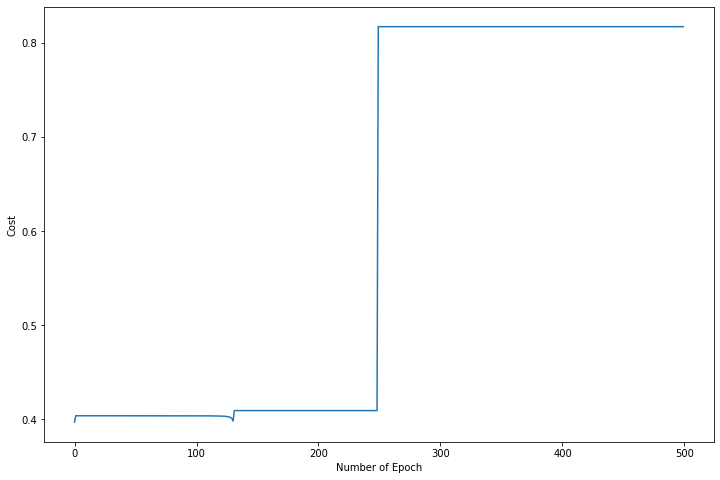

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.xlabel('Number of Epoch')
plt.ylabel('Cost')
plt.plot(graph_cost)
plt.show()